In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import trompy as tp

import dill

rcParams['font.family'] = 'Arial'

savefigs = False

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

In [2]:
with open(DATAFOLDER / "x_array_with_7clusters.pickle", "rb") as f:
    x_array = dill.load(f)

In [3]:
with open(DATAFOLDER / "snips_data_selected_conditions_reduced.pickle", "rb") as f:
    data = dill.load(f)

snips_10NaCl = data["snips_10NaCl_reduced"]
snips_45NaCl = data["snips_45NaCl_reduced"]

snips_all = np.vstack([snips_10NaCl, snips_45NaCl])
snips_all.shape

(480, 200)

In [4]:
snips_cluster = snips_all[x_array.cluster == 0, :]

In [5]:
snips_cluster.shape

(59, 200)

In [7]:
### code from hislight
#ADDING IN RANDOM SEED 
def consecutive_threshold(significant_times, min_consecutive):
    significant_periods = []
    start = None
    for i, is_significant in enumerate(significant_times):
        if is_significant:
            if start is None:
                start = i
        else:
            if start is not None:
                if i - start >= min_consecutive:
                    significant_periods.append((start, i))
                start = None
    # Check if the last period is significant
    if start is not None and len(significant_times) - start >= min_consecutive:
        significant_periods.append((start, len(significant_times)))
    return significant_periods

def analyze_peri_event_activity_with_bootstrapping(data, n_bootstraps=1000, min_consecutive=6):
    bootstrap_means = np.zeros((n_bootstraps, data.shape[1]))
    
    # Perform bootstrapping (resample with replacement)
    np.random.seed(42)
    for i in range(n_bootstraps):
        resample_indices = np.random.choice(data.shape[0], size=data.shape[0], replace=True)
        bootstrap_means[i, :] = np.mean(data[resample_indices, :], axis=0)
    
    # Calculate the 2.5th and 97.5th percentiles for the bootstrapped confidence intervals
    ci_lower = np.percentile(bootstrap_means, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_means, 97.5, axis=0)
    
    # Calculate the mean across all bootstrap samples (for plotting)
    means = np.mean(bootstrap_means, axis=0)
    
    # Flag the time points where the CI does not contain 0
    significant_above_zero = ci_lower > 0  # Significantly greater than zero
    significant_below_zero = ci_upper < 0  # Significantly less than zero
    # Combine significant times above and below zero
    significant_times = significant_above_zero | significant_below_zero
    # Apply consecutive thresholding
    significant_periods_above = consecutive_threshold(significant_above_zero, min_consecutive)
    significant_periods_below = consecutive_threshold(significant_below_zero, min_consecutive)
    significant_periods = consecutive_threshold(significant_times, min_consecutive)
    
    # Prepare the results dictionary
    results = {
        'significant_times_above': significant_above_zero,
        'significant_times_below': significant_below_zero,
        'significant_periods_above': significant_periods_above,
        'significant_periods_below': significant_periods_below,
        'significant_periods': significant_periods,
        'means': means,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }
    return results

In [11]:
# for looping through once code is working for a single cluster
bootstraps = 1000
min_consecutive = 6

for cluster in np.arange(0,7):
    print("Cluster", cluster)
    snips_cluster = snips_all[x_array.cluster == cluster, :]

    results = analyze_peri_event_activity_with_bootstrapping(snips_cluster, n_bootstraps=bootstraps, min_consecutive=min_consecutive)
    print(results['significant_periods'])

Cluster 0
[(69, 142), (144, 182)]
Cluster 1
[(67, 98), (122, 178)]
Cluster 2
[(3, 24), (43, 71), (72, 138), (144, 150)]
Cluster 3
[(67, 88), (123, 135), (136, 200)]
Cluster 4
[(0, 25), (37, 67), (71, 78), (85, 161)]
Cluster 5
[(0, 30), (42, 71), (75, 97), (115, 168)]
Cluster 6
[(73, 200)]


Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5
Cluster 6


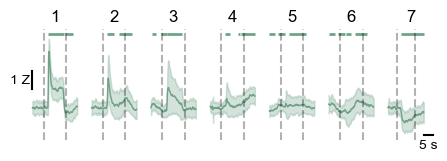

In [17]:
savefigs=False

bootstraps = 1000
min_consecutive = 12

f, ax = plt.subplots(ncols=len(x_array.cluster.unique()), sharey=True, figsize=(4.5, 1.5),
                                          gridspec_kw={'left': 0.05, 'right': 0.95, 'top': 0.85}
                                          )

for cluster in np.arange(0,7):
    print("Cluster", cluster)
    snips_cluster = snips_all[x_array.cluster == cluster, :]
    x = np.arange(snips_cluster.shape[1]) / 10
    mean = np.mean(snips_cluster, axis=0)
    sem = np.std(snips_cluster, axis=0) / np.sqrt(snips_cluster.shape[0])
    sd = np.std(snips_cluster, axis=0)
    
    ax[cluster].plot(x, np.mean(snips_cluster, axis=0), color="#6FA287", lw=1)
    ax[cluster].fill_between(x, mean-sd, mean+sd, alpha=0.3, color="#6FA287")
    ax[cluster].set_title(f"{cluster+1}")
    
    results = analyze_peri_event_activity_with_bootstrapping(snips_cluster, n_bootstraps=bootstraps, min_consecutive=min_consecutive)
    significant_periods = results['significant_periods']
    for start, end in significant_periods:
        ax[cluster].hlines(y=4, xmin=start/10, xmax=end/10, color="#6FA287", linewidth=2)
    

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.axvline(5, color="k", linestyle="--", alpha=0.3)
    axis.axvline(15, color="k", linestyle="--", alpha=0.3)
    sns.despine(ax=axis, top=True, right=True, left=True, bottom=True)
    

ax[0].plot([0, 0], [1, 2], color="k")
ax[0].text(-1, 1.5, "1 Z", ha="right", va="center", fontsize=10)

ax[6].plot([20, 25], [-1.5, -1.5], color="k")
ax[6].text(22.5, -1.7, "5 s", ha="center", va="top", fontsize=10)

if savefigs:
    f.savefig(FIGSFOLDER / "snips_clusters_waveform.pdf", dpi=600, transparent=True)

In [8]:
bootstraps = 1000
min_consecutive = 6

results = analyze_peri_event_activity_with_bootstrapping(snips_cluster, n_bootstraps=bootstraps, min_consecutive=min_consecutive)


In [10]:
results['significant_periods']

[(73, 200)]

In [ ]:
data_PVH = BS_PVH["means"]
data_VMH = BS_VMH["means"]

ci_lower_PVH = BS_PVH["ci_lower"]
ci_upper_PVH = BS_PVH["ci_upper"]
ci_lower_VMH = BS_VMH["ci_lower"]
ci_upper_VMH = BS_VMH["ci_upper"]

indices = np.arange(len(data_PVH))
mask1 = indices <= 109
mask2 = indices >= 121

f, ax = plt.subplots(figsize=[3, 3.5])
# Plot the data
ax.plot(indices[mask1], data_PVH[mask1], color=colors_PVH, label='PVH')
ax.plot(indices[mask2], data_PVH[mask2], color=colors_PVH)
ax.plot(indices[mask1], data_VMH[mask1], color=colors_VMH, label='VMH')
ax.plot(indices[mask2], data_VMH[mask2], color=colors_VMH)

# Plot the confidence intervals using fill_between
ax.fill_between(indices[mask1], ci_lower_PVH[mask1], ci_upper_PVH[mask1], color=colors_PVH, alpha=0.3)
ax.fill_between(indices[mask2], ci_lower_PVH[mask2], ci_upper_PVH[mask2], color=colors_PVH, alpha=0.3)
ax.fill_between(indices[mask1], ci_lower_VMH[mask1], ci_upper_VMH[mask1], color=colors_VMH, alpha=0.3)
ax.fill_between(indices[mask2], ci_lower_VMH[mask2], ci_upper_VMH[mask2], color=colors_VMH, alpha=0.3)

# Highlight significant periods
significant_periods_PVH = BS_PVH['significant_periods']
significant_periods_VMH = BS_VMH['significant_periods']
significant_differences = sig_no_overlap['significant_periods_non_overlap']

for start, end in significant_differences:
    ax.hlines(y=2.6, xmin=start, xmax=end, color="#A9A9A9", linewidth=3)
for start, end in significant_periods_PVH:
    ax.hlines(y=2.2, xmin=start, xmax=end, color=colors_PVH, linewidth=3)
for start, end in significant_periods_VMH:
    ax.hlines(y=1.8, xmin=start, xmax=end, color=colors_VMH, linewidth=3)
    
# Add additional plot elements
ax.hlines(y=0, xmin=0, xmax=240, color="grey", linewidth=1, linestyle="dotted")
ax.vlines(x=50, ymin=-3.2, ymax=2.6, color="grey", linewidth=1, linestyle="--")
ax.vlines(x=140, ymin=-3.2, ymax=2.6, color="grey", linewidth=1, linestyle="--")

for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(-3.6, 2.7)
ax.set_xlim(0, 240)

#scale bars
ax.plot([190,240], [-0.8, -0.8], linewidth=2, color="k", transform=blended_transform_factory(ax.transData, ax1.transAxes))
ax.plot([2,2], [-1, -2], linewidth=2, color="k")

plt.show()

f.savefig(FIGSFOLDER / "fig_4_PVH_vs_VMH_bootstrap.pdf")